In [1]:
%load_ext autoreload
%autoreload 2

# Chapter 7

## Preamble

In [109]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import pymc3 as pm
import seaborn as sns
import arviz as az
import os
import matplotlib.pyplot as plt
from rethinking.linear import *
from rethinking.plot import plot_from_sample
from IPython.core.display import display, HTML 

In [5]:
plt.style.available

['fast',
 'classic',
 '_classic_test',
 'seaborn-white',
 'seaborn-deep',
 'Solarize_Light2',
 'seaborn',
 'seaborn-pastel',
 'seaborn-talk',
 'grayscale',
 'fivethirtyeight',
 'dark_background',
 'ggplot',
 'seaborn-paper',
 'seaborn-poster',
 'seaborn-whitegrid',
 'seaborn-muted',
 'seaborn-dark-palette',
 'seaborn-colorblind',
 'tableau-colorblind10',
 'seaborn-notebook',
 'seaborn-darkgrid',
 'seaborn-bright',
 'seaborn-dark',
 'seaborn-ticks',
 'bmh',
 'arviz-white',
 'arviz-colors',
 'arviz-darkgrid',
 'arviz-whitegrid']

In [6]:
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15, round(15 / np.sqrt(2)))

In [7]:
def data(path):
    BASE = "../external/rethinking/data"  
    return pd.read_csv(f"{BASE}/{path}", sep=";")

## Fetch and preprocess data for 7H1, 7H2

In [8]:
df = data("tulips.csv")
print(f"Rows: {len(df)}")
print(f"Columns: {len(df.columns)}")
df.head()

Rows: 27
Columns: 4


,bed,water,shade,blooms
0,a,1,1,0.00
1,a,1,2,0.00
2,a,1,3,111.04
3,a,2,1,183.47
4,a,2,2,59.16


In [9]:
for variable in ["water", "shade", "blooms"]:
    df[f"{variable}_"] = df[variable] - df[variable].mean()
df.head()

,bed,water,shade,blooms,water_,shade_,blooms_
0,a,1,1,0.00,-1.0,-1.0,-128.993704
1,a,1,2,0.00,-1.0,0.0,-128.993704
2,a,1,3,111.04,-1.0,1.0,-17.953704
3,a,2,1,183.47,0.0,-1.0,54.476296
4,a,2,2,59.16,0.0,0.0,-69.833704


In [10]:
expr = ModelExpr.from_str("blooms = water_ + shade_ + water_ * shade_", df=df)

AttributeError: type object 'ModelExpr' has no attribute 'from_string'

In [11]:
def from_spec(df, target, *terms):
    y = df[target].values
    
    columns = []
    for term in terms:
        c = np.ones((len(y), 1))
        for variable in term:
            c *= df[variable].values.reshape((-1, 1))
        columns.append(c)
    return (y, np.concatenate(columns, axis=1))

def create_model(y, X):
    m = pm.Model()
    n = X.shape[1]
    with m: 
        α = pm.Normal("α", mu=0, sd=100)
        β = pm.Normal("β", mu=0, sd=100, shape=n)
        σ = pm.Uniform("σ", lower=0, upper=100)
        μ = α + pm.math.dot(X, β)
        pm.Normal("y", mu=μ, sd=σ, observed=y)
    return m

## Reproducing m7.8 and m7.9

In [12]:
specs = {0: [["water_"], ["shade_"]], 1: [["water_"], ["shade_"], ["water_", "shade_"]]}
models = {}
for (key, spec) in specs.items():
    models[key] = create_model(*from_spec(df, "blooms", *spec))
traces = {}
for (key, model) in models.items():
    traces[key] = pm.sample(model=model, draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]
Sampling 4 chains, 178 divergences: 100%|██████████| 16000/16000 [00:04<00:00, 3202.80draws/s]
There were 178 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.28128393629701004, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [00:04<00:00, 3745.13draws/s]


In [15]:
for (i, trace) in traces.items():
    print(f"Model {i}")
    display(az.summary(trace))

Model 0


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,127.346,12.439,104.385,150.923,0.209,0.148,3551.0,3551.0,3538.0,3726.0,1.0
β[0],74.107,14.763,47.856,103.417,0.225,0.159,4288.0,4288.0,4365.0,4305.0,1.0
β[1],-40.051,15.234,-67.750,-10.589,0.286,0.204,2834.0,2793.0,2826.0,3399.0,1.0
σ,63.791,9.526,47.097,81.508,0.169,0.126,3164.0,2836.0,3568.0,2635.0,1.0


Model 1


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,127.526,9.844,108.958,145.721,0.115,0.081,7331.0,7331.0,7381.0,5002.0,1.0
β[0],74.497,12.358,50.548,97.203,0.128,0.091,9258.0,9258.0,9287.0,5870.0,1.0
β[1],-40.861,12.334,-64.281,-17.705,0.142,0.102,7498.0,7329.0,7517.0,5458.0,1.0
β[2],-51.935,14.725,-79.769,-24.229,0.159,0.117,8587.0,7891.0,8604.0,5581.0,1.0
σ,51.629,7.978,37.818,66.512,0.108,0.079,5446.0,5095.0,6288.0,4463.0,1.0


## Exercise 7H1

In [16]:
for c in set(df.bed):
    df[c] = np.where(df.bed == c, 1, 0)
df.head()

,bed,water,shade,blooms,water_,shade_,blooms_,a,b,c
0,a,1,1,0.00,-1.0,-1.0,-128.993704,1,0,0
1,a,1,2,0.00,-1.0,0.0,-128.993704,1,0,0
2,a,1,3,111.04,-1.0,1.0,-17.953704,1,0,0
3,a,2,1,183.47,0.0,-1.0,54.476296,1,0,0
4,a,2,2,59.16,0.0,0.0,-69.833704,1,0,0


In [17]:
specs[2] = [["water_"], ["shade_"], ["a"], ["b"], ["c"]]
models[2] = create_model(*from_spec(df, "blooms", *specs[2]))
traces[2] = pm.sample(model=models[2], draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [00:08<00:00, 1851.52draws/s]


In [18]:
print("Model 2")
display(az.summary(traces[2]));

Model 2


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,97.919,51.101,2.895,192.430,1.125,0.796,2063.0,2063.0,2058.0,2944.0,1.0
β[0],74.497,14.597,47.232,102.062,0.194,0.140,5654.0,5439.0,5718.0,4248.0,1.0
β[1],-40.717,14.627,-67.756,-12.437,0.207,0.150,4976.0,4767.0,4997.0,4228.0,1.0
β[2],-0.695,53.196,-98.450,97.937,1.144,0.809,2163.0,2163.0,2157.0,3265.0,1.0
β[3],42.653,52.879,-59.722,137.841,1.130,0.799,2189.0,2189.0,2183.0,3361.0,1.0
β[4],47.704,52.694,-48.297,146.925,1.124,0.795,2198.0,2198.0,2192.0,2917.0,1.0
σ,61.666,9.819,44.392,79.912,0.184,0.137,2852.0,2550.0,3268.0,2119.0,1.0


## Exercise 7H2

In [19]:
def compute_measures(traces):
    waics = []
    keys = []
    for (key, trace) in traces.items():
        waics.append(az.waic(trace))
        keys.append(key)
    measures = pd.DataFrame({"waic": [w.waic for w in waics],
                             "p_waic": [w.p_waic for w in waics],
                             "keys": keys})
    measures["waic_"] = np.max(measures.waic) - measures.waic
    return measures

/home/bart/.pyenv/versions/anaconda3-5.3.1/envs/statistical-rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:1208: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,waic,p_waic,keys,waic_
0,-151.948518,3.727433,0,5.388499
1,-146.560019,4.325864,1,0.000000
2,-152.188045,5.664999,2,5.628026


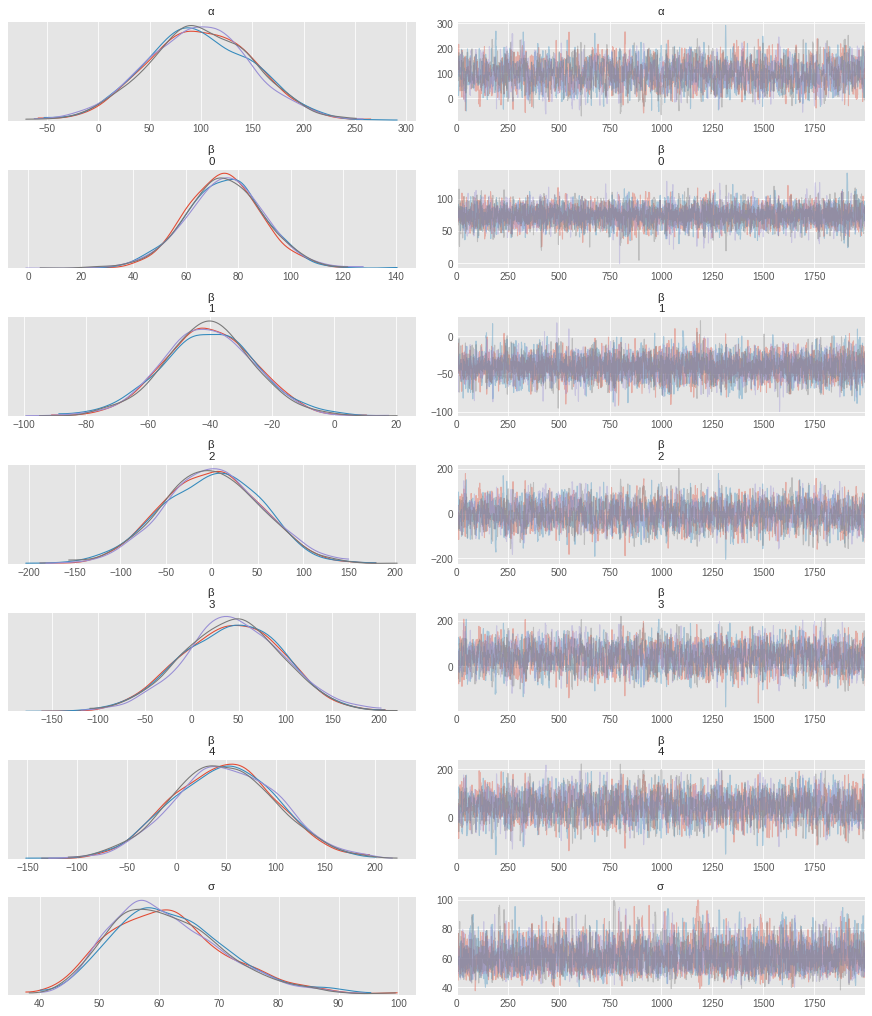

In [20]:
display(compute_measures(traces))
az.plot_trace(traces[2]);

In [22]:
specs[3] = [["water_"], ["shade_"], ["b"], ["c"]]
models[3] = create_model(*from_spec(df, "blooms", *specs[3]))
traces[3] = pm.sample(model=models[3], draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [00:05<00:00, 3186.67draws/s]


/home/bart/.pyenv/versions/anaconda3-5.3.1/envs/statistical-rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:1208: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,waic,p_waic,keys,waic_
0,-151.948518,3.727433,0,5.388499
1,-146.560019,4.325864,1,0.000000
2,-152.188045,5.664999,2,5.628026
3,-151.942398,5.502524,3,5.382379


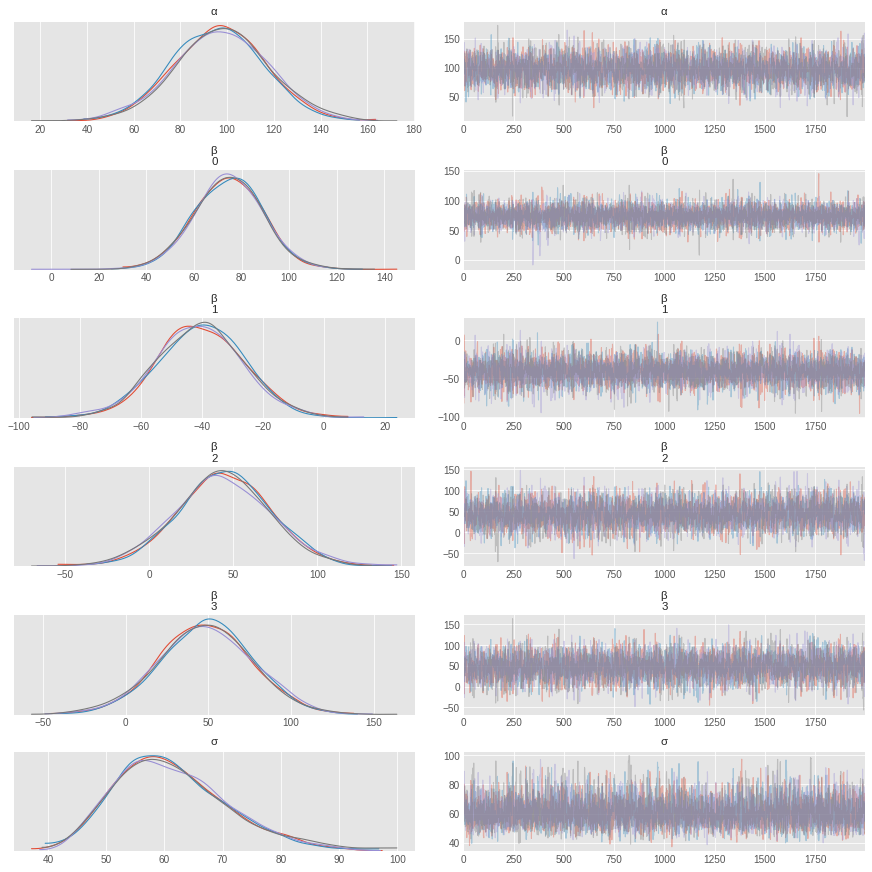

In [23]:
display(compute_measures(traces))
az.plot_trace(traces[3]);

## Exercise 7H3

### 7H3a

In [70]:
df = data("rugged.csv")[["rugged", "rgdppc_2000", "country", "cont_africa"]]
df["log_gdp"] = np.log(raw.rgdppc_2000) 
df.dropna(inplace=True)
df["rugged_"] = df["rugged"] - df["rugged"].mean()
df.head()

,rugged,rgdppc_2000,country,cont_africa,log_gdp,rugged_
2,0.858,1794.729,Angola,1,7.492609,-0.475182
4,3.427,3703.113,Albania,0,8.216929,2.093818
7,0.769,20604.460,United Arab Emirates,0,9.933263,-0.564182
8,0.775,12173.680,Argentina,0,9.407032,-0.558182
9,2.688,2421.985,Armenia,0,7.792343,1.354818


In [94]:
expr = ModelExpr.from_str("log_gdp = rugged_ + cont_africa + rugged_ * cont_africa")
kwargs = {"draws": 2000, "tune": 2000}
seychelles = (df.country == "Seychelles")
estimates = {
    "Full": pm.find_MAP(model=expr.model(df)),
    "NoSeychelles": pm.find_MAP(model=expr.model(df[~seychelles]))
}

logp = -256.08, ||grad|| = 0.091847: 100%|██████████| 34/34 [00:00<00:00, 2919.57it/s]  
logp = -253.4, ||grad|| = 0.23553: 100%|██████████| 35/35 [00:00<00:00, 3410.00it/s]  


### 7H3b

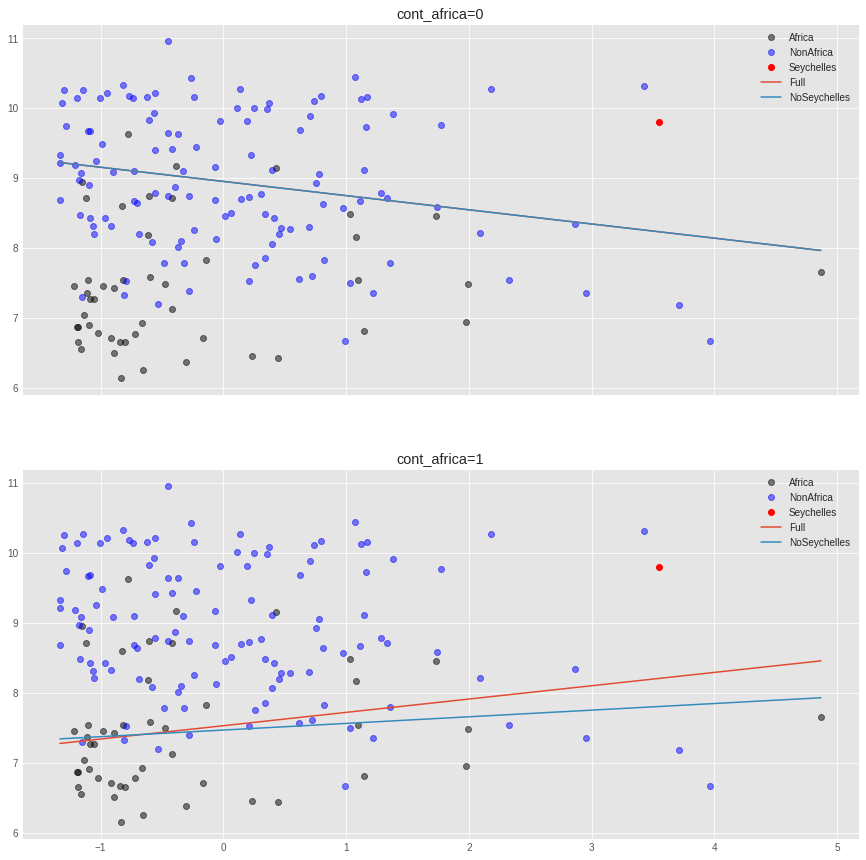

In [95]:
xs = np.linspace(df.rugged_.min(), df.rugged_.max())
data = pd.DataFrame({"rugged_": xs})
africa = df.cont_africa == 1
fix, axs = plt.subplots(2, sharex=True, sharey=True, figsize=(15, 15)) 
for (cont_africa, ax) in zip([0, 1], axs):
    ax.set_title(f"cont_africa={cont_africa}")
    data["cont_africa"] = cont_africa
    X = design_matrix(data, expr)
    ax.plot(df[~seychelles & africa].rugged_,
            df[~seychelles & africa].log_gdp, "o", color="black", alpha=0.5,
            label="Africa")
    ax.plot(df[~africa].rugged_, df[~africa].log_gdp, "o", color="blue", alpha=0.5,
            label="NonAfrica")
    ax.plot(df[seychelles].rugged_, df[seychelles].log_gdp, "o", color="red", alpha=1,
            label="Seychelles")
    for (label, est) in estimates.items():
        ax.plot(xs, est["intercept"] + np.dot(X, est["terms"]), label=label)
    ax.legend()

### 7H3c

In [96]:
exprs = [ModelExpr.from_str("log_gdp = rugged_"),
         ModelExpr.from_str("log_gdp = rugged_ + cont_africa"),
         ModelExpr.from_str("log_gdp = rugged_ + cont_africa + rugged_ * cont_africa")]
models = [expr.model(df) for expr in exprs]
traces = [pm.sample(model=model, draws=2000, tune=2000) for model in models]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, terms, intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [00:03<00:00, 4294.92draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, terms, intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [00:04<00:00, 3807.09draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, terms, intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [00:05<00:00, 3174.54draws/s]


In [113]:
for (expr, trace) in zip(exprs, traces):
    display(HTML(f"<b>{expr}</b>"))
    display(az.summary(trace))
comparison = compare_models(traces, exprs)
display(comparison.sort_values(by="waic", inplace=False, ascending=False))

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
intercept,8.517,0.091,8.352,8.692,0.001,0.001,10829.0,10829.0,10841.0,5941.0,1.0
terms[0],0.004,0.080,-0.148,0.152,0.001,0.001,10223.0,3615.0,10187.0,6166.0,1.0
sd,1.178,0.066,1.056,1.303,0.001,0.000,10705.0,10491.0,10905.0,5785.0,1.0


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
intercept,8.941,0.090,8.775,9.113,0.001,0.001,6203.0,6198.0,6199.0,5722.0,1.0
terms[0],-0.066,0.066,-0.194,0.053,0.001,0.001,8423.0,6663.0,8433.0,6206.0,1.0
terms[1],-1.469,0.168,-1.767,-1.138,0.002,0.002,5884.0,5828.0,5892.0,6196.0,1.0
sd,0.973,0.054,0.876,1.077,0.001,0.000,8395.0,8377.0,8371.0,5589.0,1.0


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
intercept,8.953,0.089,8.787,9.121,0.001,0.001,6004.0,6000.0,6014.0,5684.0,1.0
terms[0],-0.203,0.078,-0.352,-0.058,0.001,0.001,5757.0,5757.0,5772.0,5969.0,1.0
terms[1],-1.425,0.165,-1.748,-1.125,0.002,0.001,6610.0,6477.0,6644.0,6078.0,1.0
terms[2],0.394,0.133,0.139,0.649,0.002,0.001,5728.0,5728.0,5720.0,5734.0,1.0
sd,0.951,0.053,0.852,1.050,0.001,0.000,7015.0,6960.0,7074.0,5876.0,1.0


/home/bart/.pyenv/versions/anaconda3-5.3.1/envs/statistical-rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:1208: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,model,waic,p_waic,dwaic,aikake_weights
2,log_gdp = rugged_ + cont_africa + rugged_*cont_africa,-234.722883,5.166428,0.000000,8.484961e-01
1,log_gdp = rugged_ + cont_africa,-238.168592,4.330971,3.445709,1.515038e-01
0,log_gdp = rugged_,-269.870238,2.713524,35.147355,1.979241e-08


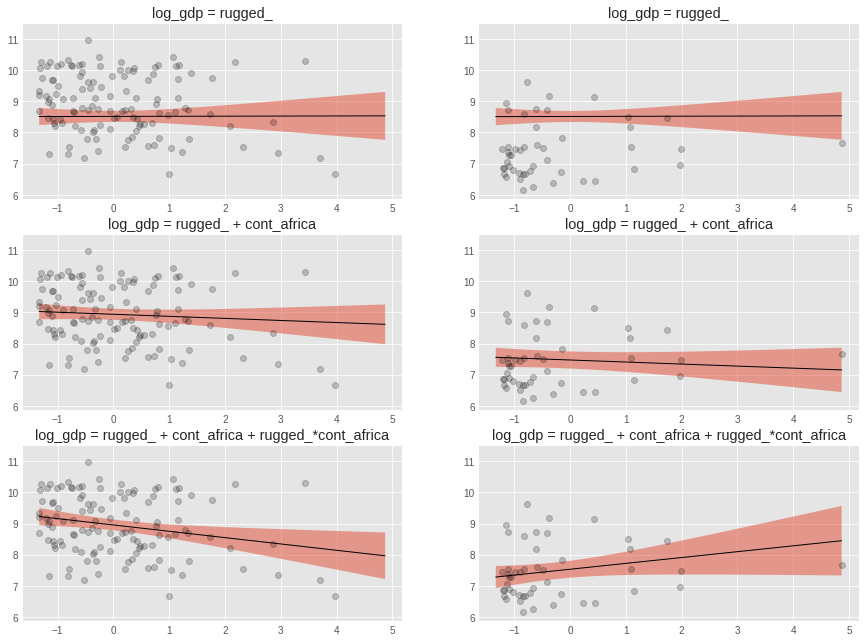

In [115]:
df_ = df[~seychelles]
fig, ax = plt.subplots(len(exprs), 2)
ylim = (df_.log_gdp.min() / 1.05, df_.log_gdp.max() * 1.05)
xs = np.linspace(df_.rugged_.min(), df_.rugged_.max())
for (i, (expr, trace)) in enumerate(zip(exprs, traces)):
    for cont_africa in range(2):
        _df = df_[df_.cont_africa == cont_africa]
        ax[i, cont_africa].set_ylim(*ylim)
        ax[i, cont_africa].plot(_df.rugged_, _df.log_gdp, "o", color="black", alpha=0.2)        
        ax[i, cont_africa].set_title(str(expr))
        plot_lm(ax[i, cont_africa], expr, trace, n=10000, rugged_=xs, cont_africa=cont_africa)

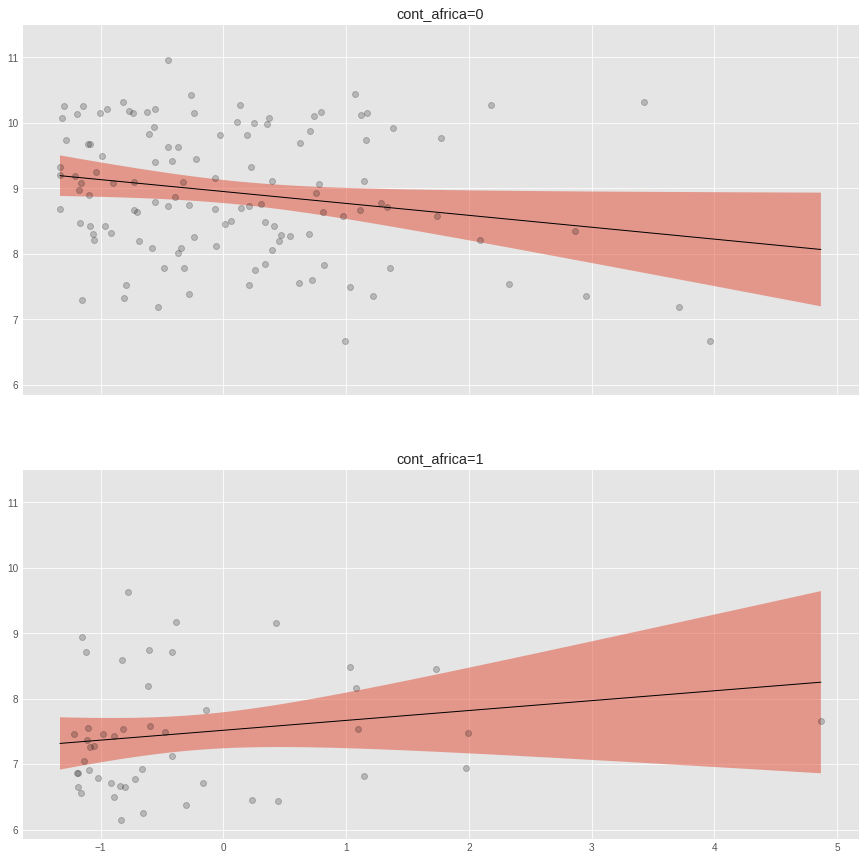

In [118]:
fig, axs = plt.subplots(2, sharex=True, sharey=True, figsize=(15, 15))
for (cont_africa, ax) in zip([0, 1], axs):
    _df = df_[df_.cont_africa == cont_africa]
    ax.set_ylim(*ylim)
    ax.plot(_df.rugged_, _df.log_gdp, "o", color="black", alpha=0.2)        
    (xs, yss) = sample_mixture(exprs, traces, n=10000, ps=comparison.aikake_weights.values,
                           rugged_=xs, cont_africa=cont_africa)
    ax.set_title(f"cont_africa={cont_africa}")
    plot_from_sample(xs, yss, ax=ax)